# Neural networks

We can try another model on the credit risk dataset. Let's try a simple feed-forward neural network.

For this we need scipy and keras packages installed in the environment. Moreover, we need to have a keras backend (Theano, Tensorflow, or Pytorch) installed. We will use Pytorch here.

In [1]:
import pandas as pd
import torch
import os
import numpy as np
from plotnine import *
import json
from sklearn.metrics import f1_score
from pathlib import Path

os.environ["KERAS_BACKEND"] = "torch" # we need to tell keras to use torch as backend

import keras

# import what we need from keras
from keras.models import Sequential
from keras.layers import Dense

import keras_tuner as kt

# Print the version of PyTorch and keras
print("Torch version:", torch.__version__)
print("Keras version:", keras.__version__)

# Check if CUDA is available and print the result
# CUDA (Compute Unified Device Architecture) is a parallel computing platform and application programming interface (API) model created by Nvidia.

# It allows developers to use Nvidia GPUs for general purpose processing (an approach known as GPGPU, General-Purpose computing on Graphics Processing Units).
# PyTorch can leverage CUDA to perform tensor computations on Nvidia GPUs, which can significantly speed up training and inference of deep learning models.
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.5.1+cu124
Keras version: 3.6.0
CUDA available: True


In [2]:
# we now load the usual data
data = pd.read_pickle(Path("..", "datasets", "computed", "credit_risk_splits.pickle"))

data.keys()

X_train = data['X_train']
y_train = data['y_train']

X_validation = data['X_validation']
y_validation = data['y_validation']

X_test = data['X_test']
y_test = data['y_test']

one_hot_encoder = data['one_hot_encoder']
standard_scaler = data['standard_scaler']

X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, y_validation])

In [3]:
# The number of neurons for the input layer must match the number of features in the input data.
# X_train.shape[1] gives the number of features (columns) in the training dataset.
# Therefore, the input layer must have the same number of neurons as there are features in the input data.
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

The number of neurons for the input layer must be: 29


In [4]:
# define the neural network model class instance
simple_nn = Sequential()

# add the first input layer with 29 nodes and the first hidden layer, with  relu activation function
# note that the first command does two things: create a first input layer with 29 nodes, and then a hidden layer
# we set the number of neurons to be equal to the (# of nodes in the input layer + # neurons in the output layer)/2,
# i.e. the mean of the number of neurons in the input layer and the output layer. This is usually a good heuristic to get started.
simple_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))

# add the output layer with sigmoid function (the sigmoid function is exactly the same as that used in the formulation of logisitc regression
simple_nn.add(Dense(1, activation='sigmoid'))

/home/rpinosio/miniconda3/envs/ddb_tutorial/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [5]:
print(simple_nn.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 621 (2.43 KB)

 Trainable params: 621 (2.43 KB)

 Non-trainable params: 0 (0.00 B)

None


After the model has been defined, it needs to be compiled to tensorflow code to be able to be trained.

Here we also need to choose the cost function to optimize for in the backpropagation algorithm.
Since we are doing classification, we will use cross entropy. 

As the algorithm for to do backpropagation, we will use adam. See https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ for a gentle tutorial on stochastic gradient descent using adam.

In [6]:
simple_nn.compile(loss='binary_crossentropy', optimizer='adam')

Note that we use the binary_crossentropy loss function in the above model. Remember that the loss function is the function that encodes the error of the prediction by the NN on a given observation w.r.t. the observation's true value. The gradient descent algorithm tries to adjust the weights of the neural network so that this error is minimized. 

The cross entropy function for a binary classification problem is defined as:

-(y log(p) + (1-y) log(1-p))

where y is the actual label (0 or 1), and p is the probability that the model predicts for the 1 (positive) class.

The underlying intuition is that the cross entropy loss increases the more the predicted probability for the correct class (in the range 0-1) differs from the correct class (either 0 or 1).

<div>
<img src="../img/logloss.png" width="500">
</div>

See https://machinelearningmastery.com/cross-entropy-for-machine-learning/ for a more extensive discussion of the cross entropy and log loss functions.

Now that we have the compiled model, we can fit it on the training set. The interface here is similar to that of sklearn: we can call the .fit method on the compiled simple_nn model, and fit our model on the training set.

Note that training for a neural network model in keras goes a bit differently that for other machine learning algorithms. Here, training occurs over different **epochs**. Each **epoch** is split into **batches**. Epochs and batches are defined as:

- epoch: one forward-and-backprop pass through every row in the training set
- batch: the number of samples that are considered for each backpropagation update of the weights of the network

Each epoch consists of multiple weights update actions, one for each batch that the training dataset is divided into. There are two extreme cases: all the observations in training are in one single batch, or each individual observations is in its own separate batch.

In the first case, the model will:
1. calculate the error from all the observations in the unique batch 
2. use it do update the weights of the network
3. complete the epoch

In the second case, the model will:
1. calculate the error for the first batch (first observation)
2. update the weights of the network
3. calculate the error for the second batch (second observation)
4. update the error
5. repeat the steps above for all the observations in the training set
6. complete the epoch

Of course, these are two extreme cases. But one can set different values for the batch size, e.g., 10. Then the observations are grouped in groups of size 10 (the batches), and the algorithm loops though each batch, predicting, backpropagating, and updating the weights after each batch. When all batches are done, one epoch has passed.

Terminology:

- Batch Size = Size of Training Set -> Batch Gradient Descent
- Batch Size = 1 -> Stochastic Gradient Descent
- 1 < Batch Size < Size of Training Set -> Mini-Batch Gradient Descent


<div>
<img src="../img/batches_epochs.jpeg" width="500">
</div>

In [7]:
print(f"Shape of X_train (features for training data): {X_train.shape}")
print(f"Shape of y_train (labels for training data): {y_train.shape}")
print(f"Shape of X_validation (features for validation data): {X_validation.shape}")
print(f"Shape of y_validation (labels for validation data): {y_validation.shape}")

Shape of X_train (features for training data): (19200, 29)
Shape of y_train (labels for training data): (19200,)
Shape of X_validation (features for validation data): (4800, 29)
Shape of y_validation (labels for validation data): (4800,)


In [8]:
simple_nn.fit(X_train, y_train, epochs=100, batch_size = 20)

Epoch 1/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.5398
Epoch 2/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4408
Epoch 3/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4417
Epoch 4/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4389
Epoch 5/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4334
Epoch 6/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.4425
Epoch 7/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4345
Epoch 8/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.4342
Epoch 9/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.4271
Epoch 10/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.4335
Epoch 11/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4304
Epoch 12/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.4270
Epoch 13/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.4332
Epoch 14/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.4345
Epoch 15/100
960/960 ━━━━━━━━━━

Note that when we fit the model, keras prints the value of the loss function at the end of each epoch. Here, the value of the loss function is calculated on the training set itself.
You can see that the loss is monotonically decreasing over the epochs, until it reaches a plateau:

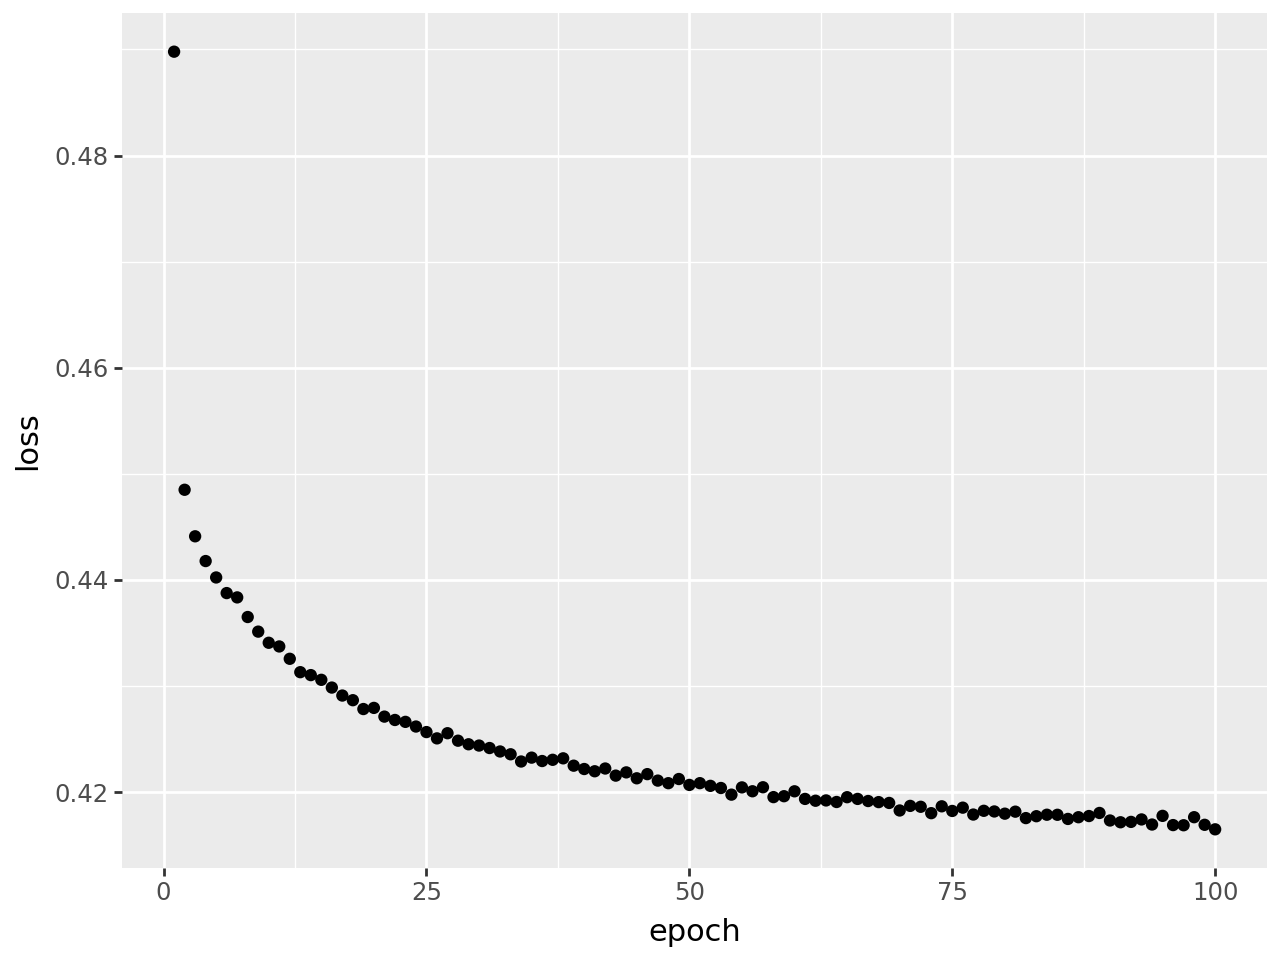

In [9]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 101))

(
    ggplot(loss_df, aes(x='epoch', y='loss')) +
    geom_point()
)

We can see that the training loss is decreasing almost linearly after each epoch. This suggests that we could in principle increase the number of epochs to achieve better predictions.

However, note that this is the loss computed at the end of each epoch on the **training set**. Thus, just looking at this loss can lead to **overfitting**. Increasing the number of epochs radically will lower the loss on the training set, but the loss on a set that the model has not been trained on could be much worse if the model is just reducing the loss on the training set by learning noise.

We can provide our validation dataset to keras in order to evaluate, at the end of each epoch, the loss on the validation dataset. This will allow us to detect if the model starts to overfit, for instance.

Note that in the next step i increase the batch size to 64. This is to make better use of gpu utilization (on my machine, at least).

In [10]:
simple_nn.fit(X_train, y_train, epochs=100, batch_size = 64, validation_data=(X_validation, y_validation))

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4168 - val_loss: 0.4360
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4190 - val_loss: 0.4356
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4106 - val_loss: 0.4377
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4161 - val_loss: 0.4368
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4055 - val_loss: 0.4365
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4157 - val_loss: 0.4368
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4072 - val_loss: 0.4371
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4125 - val_loss: 0.4391
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.4115 - val_loss: 0.4373
Epoch 10/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4073 - val_loss: 0.4365
Epoch 11/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.4122 - val_loss: 0.4366
Epoch 12/100
300/300 ━━━━━━━━━━━━━━━

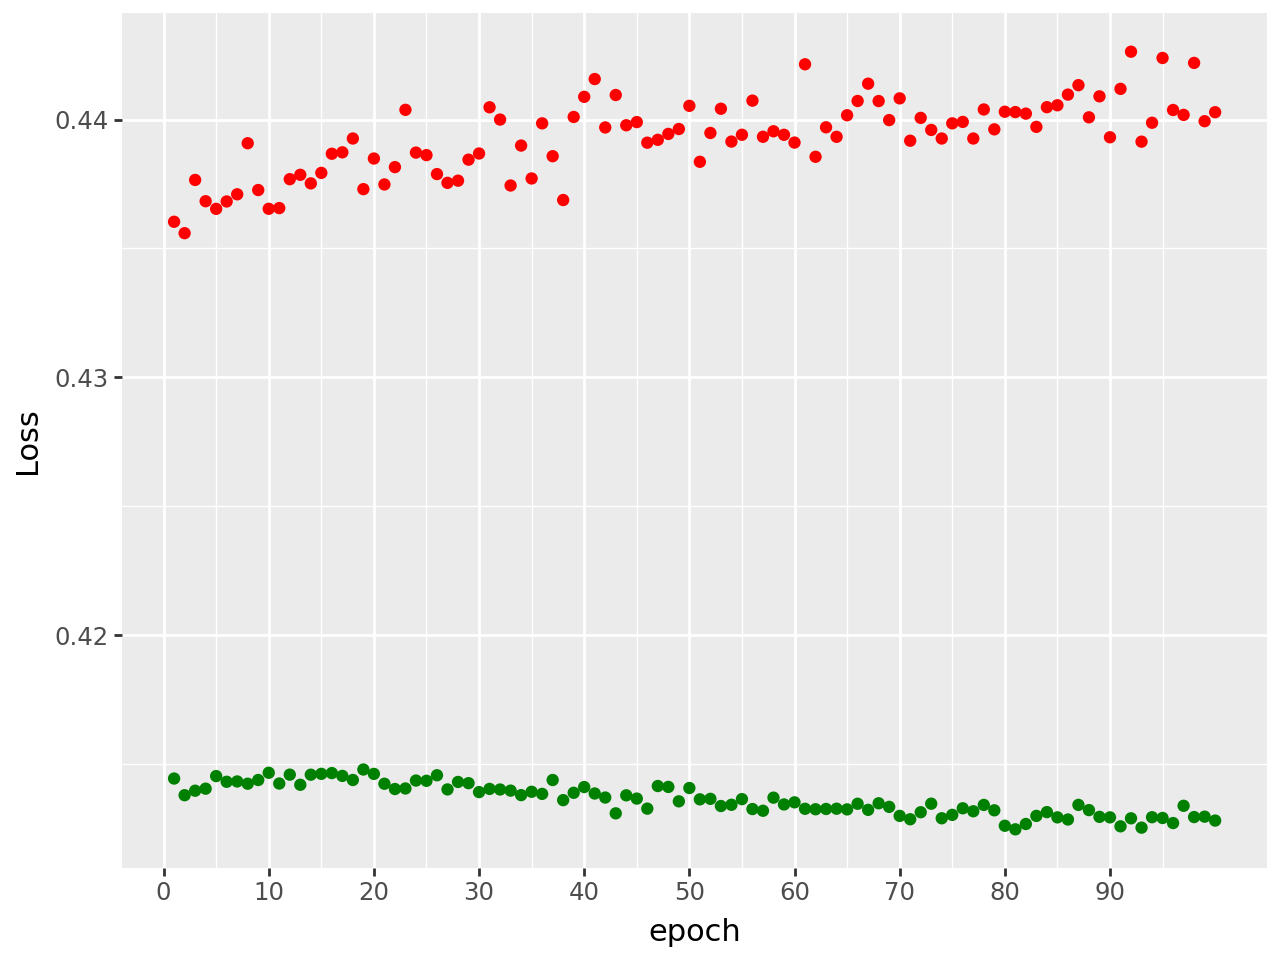

In [11]:
# plot the training loss over epochs
def plot_loss(nn_model):
    loss_df = pd.DataFrame({
        'train_loss': nn_model.history.history['loss'],
        'val_loss': nn_model.history.history['val_loss']
    })
    loss_df = loss_df.assign(epoch = np.arange(1, 101))

    p = (
        ggplot(loss_df) +
        geom_point(aes(x='epoch', y='train_loss'), color='green') +
        geom_point(aes(x='epoch', y='val_loss'), color='red') +
        scale_x_continuous(breaks = np.arange(0, 100, 10)) +
        ylab("Loss")
    )
    return p

plot_loss(simple_nn)

Note how the validation loss starts immediiately to increase after the first epochs. This is a clear sign of overfitting, and that we want to keep the number of epochs low.

In [12]:
# save the above simple nn fitted model to look at it later. We need to use the keras save command
# this command will save all the components of the model, in particular the architecture and the weights
# note: it will NOT save the training history. This needs to be saved separately.
simple_nn.save('../datasets/computed/simple_nn_model.keras')

print("Storing the fitting history of simple nn to disk")
with open('../datasets/computed/simple_nn_history.json', 'w') as handle:
    json.dump(simple_nn.history.history, handle)

Storing the fitting history of simple nn to disk


In [13]:
# we can load the above save model like this:
simple_nn = keras.models.load_model("../datasets/computed/simple_nn_model.keras")
simple_nn

# reload the fitting history like this
with open("../datasets/computed/simple_nn_history.json", "r") as handle:
    simple_nn_history = json.load(handle)

After we have determined at least the number of epochs that give us the best results on the validation dataset, we can train the model on the full train + validation set, and predict on the test set to get a final value for the model performance.

In [14]:
final_nn = Sequential()
final_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
final_nn.add(Dense(1, activation='sigmoid'))
final_nn.compile(loss='binary_crossentropy', optimizer='adam')
final_nn.fit(X_train_validation, y_train_validation, epochs=50, batch_size = 20, verbose=0)
y_hat_test_nn = final_nn.predict(X_test)
y_hat_test_nn = np.where(y_hat_test_nn >= 0.5, 1, 0)
print("The f1 score of the nn model is {}".format(f1_score(y_test, y_hat_test_nn)))

/home/rpinosio/miniconda3/envs/ddb_tutorial/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The f1 score of the nn model is 0.4704156479217604


We have improved on the score for e.g. the SVC, as we now have ~0.465 as f1 score rather than the 0.45 produced by the SVC.
Note however that there is a lot of randomness built in neural network models. If we reran the fitting process of the above model, most likely we would obtain slightly different results.
It is best practice to fit a selected model multiple times and generate multiple scores on the test set. These can highlight if there are stability issues with the model, in case there is a large variance in the scores so produced. Moreover, they can be averaged to obtain a final preformance metric for the model on the test set.

If we try with a network with a lot of hidden neurons and hidden layers, we see that we will start overfitting very rapidly: the loss on the validation set will start to skyrocket almost immediately, while the loss on the training set will keep decreasing monotonically.

In general, the number of neurons and hidden layers in the network influences a lot the performance of the network. If you have many hidden layers with a lot of neurons, and the dimensionality of your data (# of features) is much smaller than the number of hidden neurons in the network, you are very likely to overfit the data.

On the other hand, if you have few neurons compared to the dimensionality of your data; for instance if you have hundreds of features (such as in image recognition problems, where each pixel is a feature), but just one hidden layer with 10 neurons, or even no hidden layer (in which case the neural network reduces to a linear regression), then you are very likely to underfit the data.

In [15]:
oversized_nn = Sequential()
oversized_nn.add(Dense(60, input_dim=X_train.shape[1], activation='relu'))
oversized_nn.add(Dense(40, activation='relu'))
oversized_nn.add(Dense(15, activation='relu'))
oversized_nn.add(Dense(1, activation='sigmoid'))
oversized_nn.compile(loss="binary_crossentropy", optimizer="adam")
oversized_nn.fit(X_train, y_train, epochs=100, batch_size = 20, validation_data=(X_validation, y_validation))

Epoch 1/100
 11/960 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.6590

/home/rpinosio/miniconda3/envs/ddb_tutorial/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


960/960 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.4839 - val_loss: 0.4419
Epoch 2/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.4427 - val_loss: 0.4323
Epoch 3/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.4350 - val_loss: 0.4325
Epoch 4/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.4316 - val_loss: 0.4360
Epoch 5/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.4207 - val_loss: 0.4285
Epoch 6/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.4284 - val_loss: 0.4320
Epoch 7/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.4193 - val_loss: 0.4337
Epoch 8/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.4251 - val_loss: 0.4320
Epoch 9/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.4191 - val_loss: 0.4309
Epoch 10/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.4162 - val_loss: 0.4331
Epoch 11/100
960/960 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.4113 - val_loss: 0.4314
Epoch 12/100
960/960 ━━━━━━━━━━

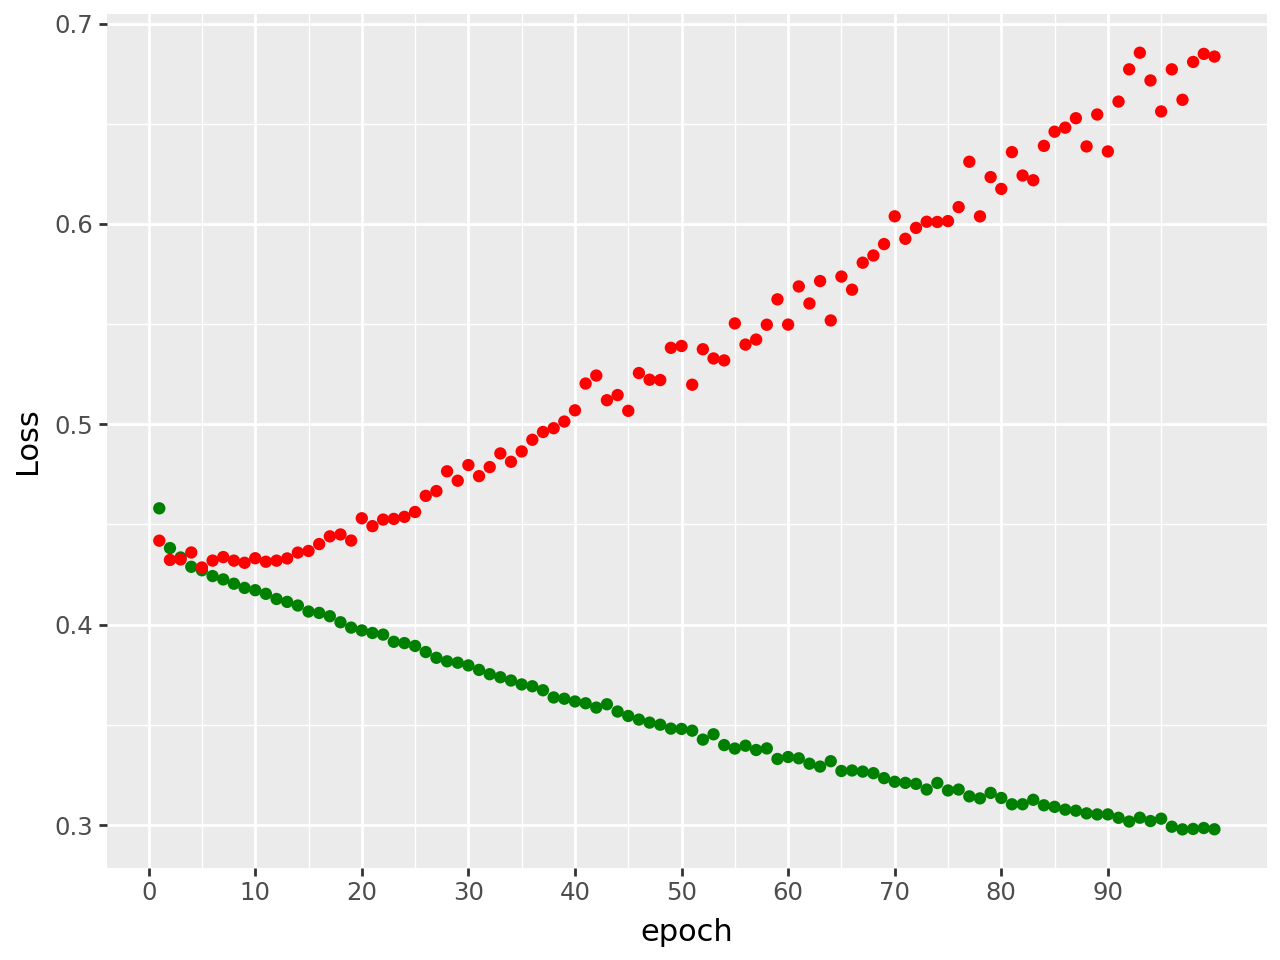

In [16]:
plot_loss(oversized_nn)

We can see that the neural network starts overfitting almost immediately.
In general, it is a good heuristic to start with a simple network with a # of hidden neurons equal to around half of the dimensionality of the feature space. However, the best number of neurons can best be determined with hypertuning.

## Hypertuning of neural network: batches, epochs, layers

There are many hyperparameters that can be tuned for neural networks: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Here we just show how we can tune batch size and number of neurons in the hidden layers, with a simple grid search.
The number of epochs we don't tune, rather, we use early stopping to stop the training when the validation loss starts to increase.

Note that in the above link, they use keras.wrappers.scikit_learn to turn a keras model into a sklearn model. However, this method is superseded by the [keras tuner](https://keras.io/guides/keras_tuner/getting_started/) package, which is more flexible and powerful.

In [17]:
seed = 1234
np.random.seed(seed)

class MyTuner(kt.HyperModel):
    # Define the hypermodel
    def build(self, hp):
        nn_model = Sequential()
        
        # define the search space for the number of neurons, for a single hidden layer
        # if you want to use multiple hidden layers, you can define the search space for each hidden layer
        neurons = hp.Int('neurons', min_value=32, max_value=64, step=32) 
        nn_model.add(Dense(neurons, activation="relu"))
        nn_model.add(Dense(1, activation='sigmoid'))
        nn_model.compile(loss='binary_crossentropy', optimizer='adam')
        return nn_model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32]), # define the search space for the batch size
            **kwargs,
        )
        
tuner = kt.RandomSearch(
    MyTuner(),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    directory="../datasets",
    project_name="tune_hypermodel",
)

# instead of tuning the number of epochs, we use early stopping to stop the training process when the validation loss does not decrease anymore.
tuner.search(X_train_validation, y_train_validation, epochs=10, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3)])

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best number of neurons: {best_hps.get('neurons')}")

Trial 3 Complete [00h 01m 07s]
val_loss: 0.4325035512447357

Best val_loss So Far: 0.42938411235809326
Total elapsed time: 00h 04m 24s
Best number of neurons: 32
